# Convolutional Neural Networks

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/Workshops/blob/main/Computer_Vision_Using_Deep_Learning/Computer_Vision_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

In this tutorial we will build a CNN based model using TensorFlow

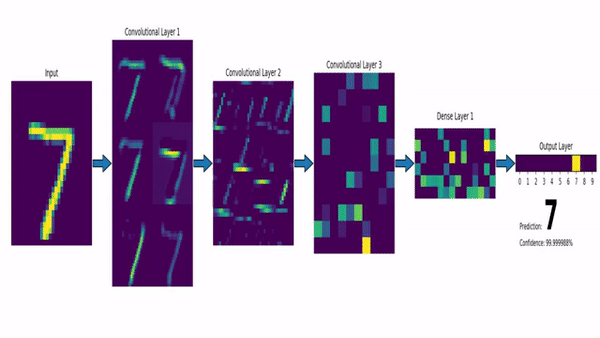

### Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
#convert the labels to one hot vector
y_train=tf.one_hot(y_train,depth=10)
y_test=tf.one_hot(y_test,depth=10)
#reshape the y_train and y_test from (50000,1,10),(10000,1,10)to (50000,10),(10000,10)
y_train=tf.reshape(y_train,[-1,10])
y_test=tf.reshape(y_test,[-1,10])

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


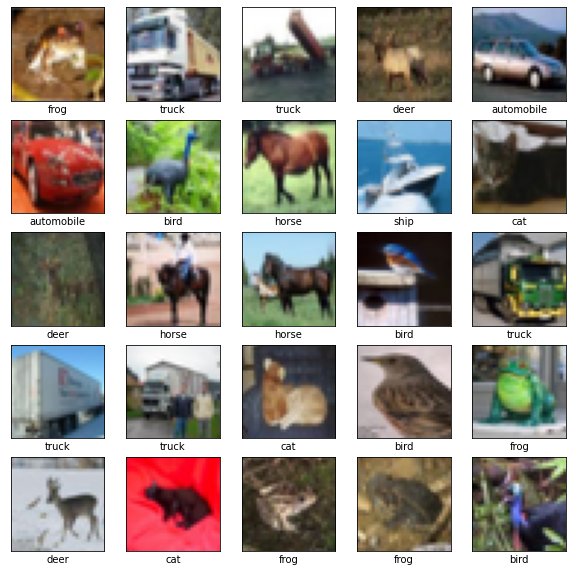

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[tf.argmax(y_train[i])])
plt.show()

## Building an image data pipeline


The Dataset API allows you to build an asynchronous, highly optimized data pipeline to prevent your GPU from data starvation. It loads data from the disk (images or text), applies optimized transformations, creates batches and sends it to the GPU. Former data pipelines made the GPU wait for the CPU to load the data, leading to performance issues.

Before explaining how tf.data works with a simple example.
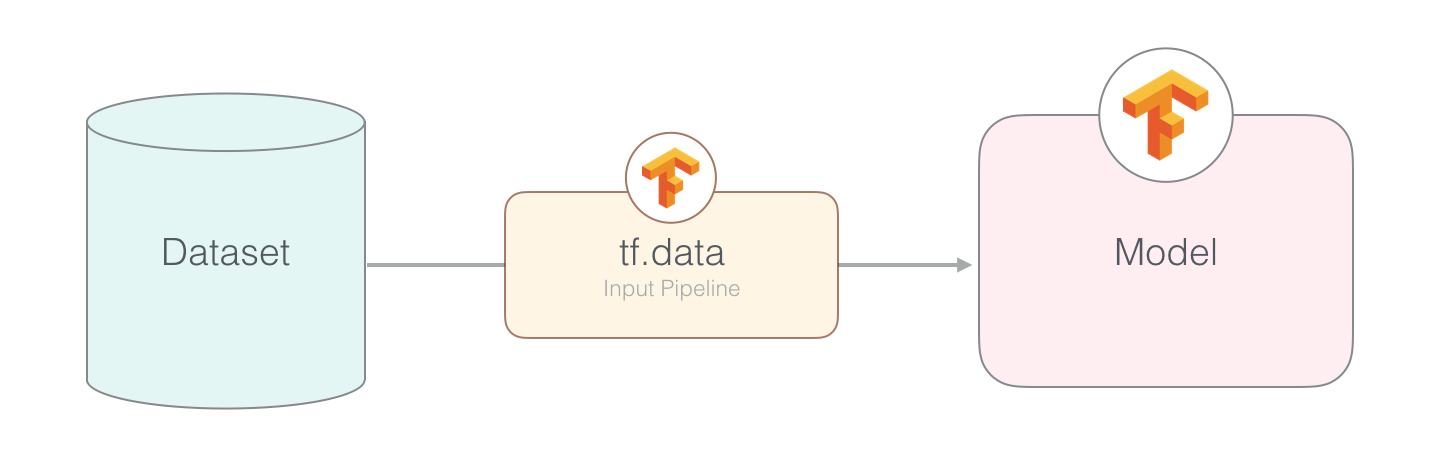

## Basic mechanics
To create an input pipeline, you must start with a data source. For example, to construct a Dataset from data in memory, you can use tf.data.Dataset.from_tensors() or tf.data.Dataset.from_tensor_slices(). Alternatively.

Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on the tf.data.Dataset object. For example, you can apply per-element transformations such as Dataset.map(), and multi-element transformations such as Dataset.batch().

The Dataset object is a Python iterable. This makes it possible to consume its elements using a for loop:




In [ ]:
def dataset_creater(x,y):
    data=tf.data.Dataset.from_tensor_slices((x,y))
    data=data.shuffle(1024)#shuffle the data
    data=data.batch(32)#creat mini-batch
    data=data.prefetch(tf.data.AUTOTUNE)#This allows later elements to be prepared while the current element is being processed.     
    return data

In [ ]:
train_dataset=dataset_creater(x_train,y_train)
test_dataset=dataset_creater(x_test,y_test)

shape of x: (32, 32, 32, 3)
shape of y: (32, 10)


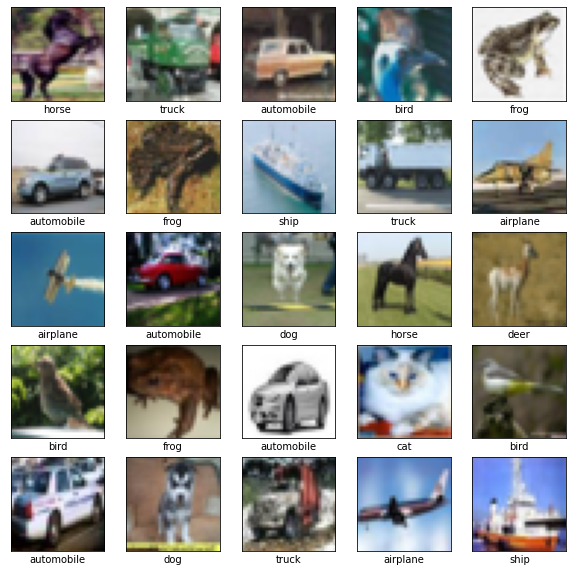

In [ ]:
for x,y in train_dataset.take(1):
    x=x
    y=y
print('shape of x:',x.shape)
print('shape of y:',y.shape)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[tf.argmax(y[i])])
plt.show()

### Data Augmentation
Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.

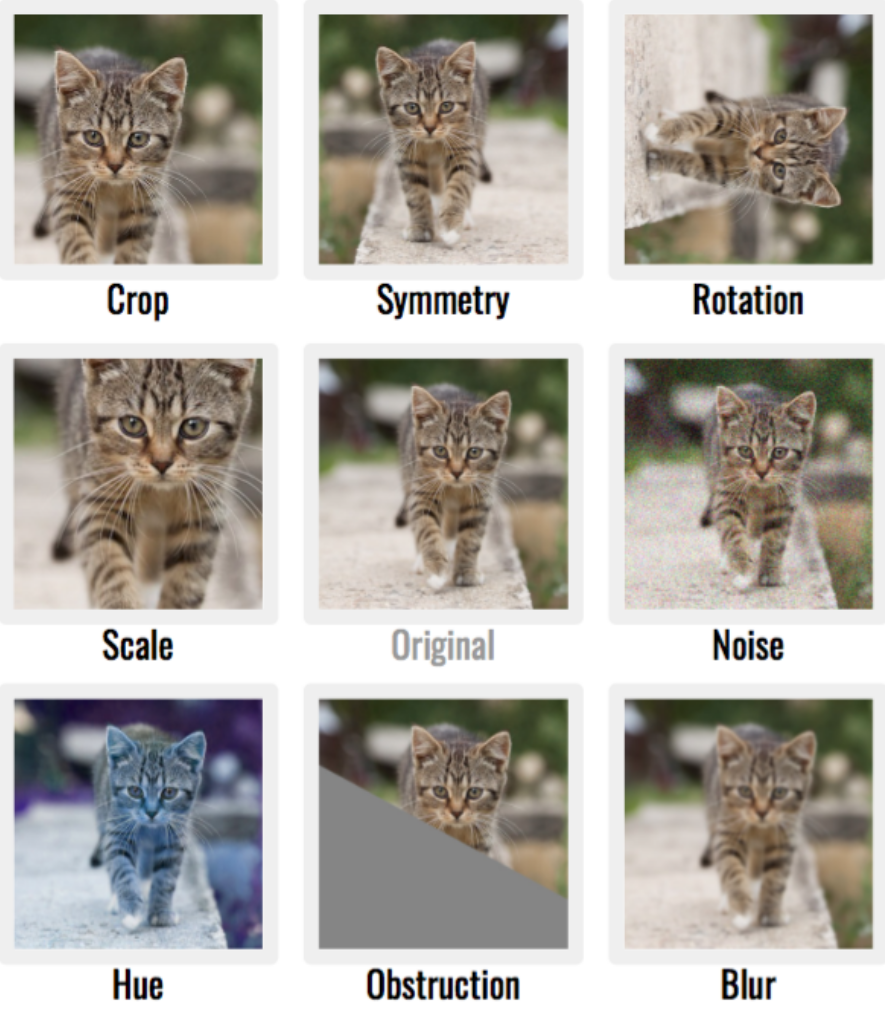

In [ ]:
def train_preprocess(image, label):
    
    image=tf.image.convert_image_dtype(image,dtype=tf.float32)#convert the image the pixel values to be in the range [0,1]
    image = tf.image.random_flip_left_right(image)#randomly flip the image
    image=tf.image.random_flip_up_down(image)#randomly flip the image

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)#randomly change the brightness of the image
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)#randomly change the saturation of the image

    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [ ]:
def dataset_creater(x,y):
    data=tf.data.Dataset.from_tensor_slices((x,y))
    data=data.shuffle(1024)#shuffle the data
    data=data.map(train_preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data=data.batch(32)#creat mini-batch
    
    return data

In [ ]:
train_dataset=dataset_creater(x_train,y_train)
test_dataset=dataset_creater(x_test,y_test)

shape of x: (32, 32, 32, 3)
shape of y: (32, 10)


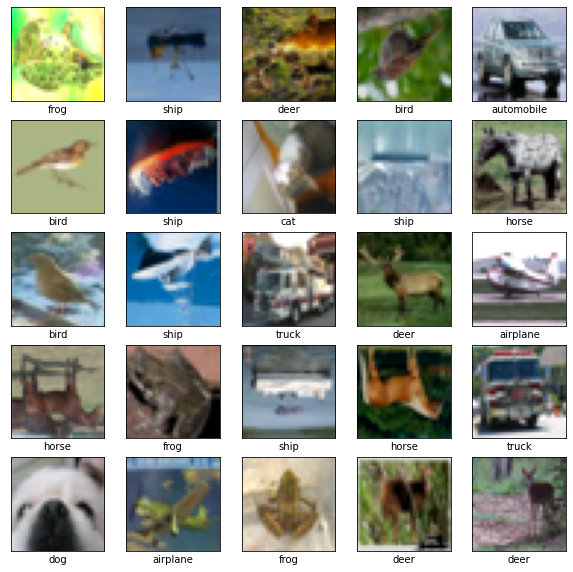

In [ ]:
for x,y in train_dataset.take(1):
    x=x
    y=y
print('shape of x:',x.shape)
print('shape of y:',y.shape)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[tf.argmax(y[i])])
plt.show()

# Build the Model

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Input([32,32,3])
,tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same')
,tf.keras.layers.MaxPooling2D((2, 2))
,tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')
,tf.keras.layers.MaxPooling2D((2, 2))
,tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same')
,tf.keras.layers.MaxPooling2D((2, 2))
,tf.keras.layers.Flatten()
,tf.keras.layers.Dense(256, activation='relu')
,tf.keras.layers.Dropout(0.3)
,tf.keras.layers.Dense(128, activation='relu')
,tf.keras.layers.Dropout(0.2)
,tf.keras.layers.Dense(10,activation=tf.nn.softmax)


]
)

**Let**'s display the architecture of our model so far.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)             

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 , 64 or 128). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.
As you can see, our (4, 4, 128) outputs from the max_pooling2d_6 were flattened into vectors of shape (2048) before going through three Dense layers.

### Compile and Train the Model

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=20, 
                    validation_data=(test_dataset),callbacks=[tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True)])

Epoch 1/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.9116 - accuracy: 0.2784 - val_loss: 1.3527 - val_accuracy: 0.4897
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3613 - accuracy: 0.5023 - val_loss: 1.1541 - val_accuracy: 0.5797
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1854 - accuracy: 0.5769 - val_loss: 1.1404 - val_accuracy: 0.5967
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0771 - accuracy: 0.6183 - val_loss: 1.1183 - val_accuracy: 0.6026
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0108 - accuracy: 0.6412 - val_loss: 0.9328 - val_accuracy: 0.6724
Epoch 6/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9623 - accuracy: 0.6626 - val_loss: 0.8857 - val_accuracy: 0.6842
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9230 - accuracy: 0.6772 - val_loss: 0.9357 - val_accuracy

In [ ]:
train_info=pd.DataFrame(history.history)
train_info

loss  accuracy  val_loss  val_accuracy
0   1.693720   0.37008  1.352671        0.4897
1   1.305676   0.52712  1.154112        0.5797
2   1.153190   0.59060  1.140401        0.5967
3   1.056770   0.62512  1.118271        0.6026
4   0.995031   0.64770  0.932774        0.6724
5   0.951867   0.66622  0.885713        0.6842
6   0.916116   0.68080  0.935684        0.6656
7   0.884264   0.69218  0.854396        0.6990
8   0.854357   0.70144  0.811865        0.7154
9   0.834400   0.70986  0.837125        0.7051
10  0.812486   0.71966  0.819322        0.7149
11  0.798928   0.72324  0.806095        0.7150
12  0.781221   0.72970  0.814770        0.7128
13  0.770164   0.73184  0.858330        0.7083
14  0.754156   0.73786  0.779639        0.7259
15  0.740876   0.74220  0.760374        0.7366
16  0.732793   0.74476  0.786570        0.7216
17  0.722312   0.74982  0.773851        0.7290
18  0.706402   0.75306  0.728431        0.7451
19  0.697174   0.75756  0.770485        0.7311

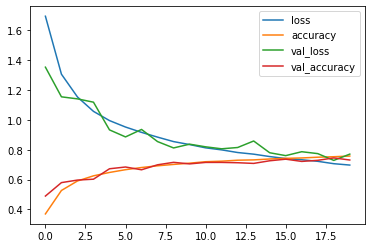

In [ ]:
train_info.plot.line()